In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Cutting 

from cut_audio import *

%matplotlib inline

## Import Data

In [111]:
N = 100

train_audio_path = join('..','Project','data','train','audio')
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])

In [112]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
print('Number of signals : ' + str(len(features_og)))

Number of signals : 3000


In [113]:
def load_audio_file(features_og):
    audio_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([('audio','raw',''),('audio','sr',''),('audio','cut','')]),index=features_og.index)

    for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
      
        audio, sampling_rate = librosa.load(features_og[('info','path')].iloc[w], sr=None, mono=True)
        audio_df.loc[w,('audio','raw','')] = audio
        audio_df.loc[w,('audio','sr','')] = sampling_rate
        audio_df.loc[w,('audio','cut','')] = cut_signal(audio)

        
    audio_df = features_og.merge(audio_df,left_index=True,right_index=True)
        
    return audio_df



In [114]:
raw_audio_df = load_audio_file(features_og)
raw_audio_df.to_pickle('./Features Data/raw_audio_100.pickle')


100%|██████████| 3000/3000 [07:13<00:00,  6.92waves/s]


## Extract the Features

In [2]:
### MFCC & STATS FUNCTION : 

def compute_mfcc_stat(features_og,N_MFCC,cut=True):
    ''' 
    This function computes the raw MFCC parameters with default parameters and the the stats
    '''
    
    stat_name= ['mean','std','skew','kurtosis','median']
    col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
    
    features_mfcc = pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
    # sorting the columns in order to improve index performances (see lexsort errors)
    features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

    # MFCC FEATURES :
    for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
        # Handling the cut version of the signal : 
        if cut == True :  
            audio = features_og.loc[w,('audio','cut','')]
        else : 
            audio = features_og.loc[w,('audio','raw','')]
            
        sampling_rate = features_og.loc[w,('audio','sr','')]
        
        # Computing the MFCC for each signal : 
        mfcc = librosa.feature.mfcc(y=audio,sr=sampling_rate, n_mfcc=N_MFCC)
        
        # Computing the MFCC stats for each signal : 
        features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
        features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
        features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
        features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
        features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)

    features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)    
    return features_og

### RAW MFCC FUNCTION : 

def compute_mfcc_raw(features_og,N_MFCC,N_FFT,NUM_MFCCS_VEC,cut=True):
    ''' 
    This function computes the raw MFCC parameters for and allow the choice of parameters
    '''
    
    stat_name= ['raw_mfcc']
    col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC*NUM_MFCCS_VEC)]

    features_mfcc = pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
    # sorting the columns in order to improve index performances (see lexsort errors)
    features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

    # MFCC FEATURES :
    for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
        # Handling the cut version of the signal : 
        if cut == True :  
            audio = features_og.loc[w,('audio','cut','')]
        else : 
            audio = features_og.loc[w,('audio','raw','')]   
            
        sampling_rate = features_og.loc[w,('audio','sr','')]
        
        # Computing the MFCC for each signal : 
        mfcc = librosa.feature.mfcc(y=audio,sr=sampling_rate, n_mfcc=N_MFCC, n_fft = N_FFT, hop_length = int(np.floor(len(audio)/NUM_MFCCS_VEC)))
     
        features_mfcc.loc[w, ('mfcc', 'raw_mfcc')] = mfcc[:,:-1].reshape(-1,)

    features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)    
    return features_og


### Loading Raw Audio DF : 

In [451]:
# Load raw audio files :
raw_audio_df = pd.read_pickle(join('..','Project','data','raw_audio_100.pickle'))
raw_audio_df.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         1  ../Project/data/train/audio/bed/26e9ae6b_nohas...  26e9ae6b  bed   
1         0  ../Project/data/train/audio/bed/c1eebc0b_nohas...  c1eebc0b  bed   
2         0  ../Project/data/train/audio/bed/888a0c49_nohas...  888a0c49  bed   
3         0  ../Project/data/train/audio/bed/413997c1_nohas...  413997c1  bed   
4         1  ../Project/data/train/audio/bed/2be08ce4_nohas...  2be08ce4  bed   

                                               audio         \
                                                 raw     sr   
                                                              
0  [0.00012207, 0.000152588, 0.00012207, 0.000183...  16000   
1  [-0.0022583, -0.00372314, -0.00448608, -0.0041...  16000   
2  [0.00283813, 0.00305176, 0.00296021, 0.0027771...  16000   
3  [0.00213623, 0.00354004, 0.00323486, 0.0036010...  16000   
4  [0.000976562, 0.00231934, 0.00180054, 0.001068...  16000   

                                                      
                                                 cut  
                                                      
0  [-6.10352e-05, -0.00012207, -9.15527e-05, -6.1...  
1  [-0.000488281, -0.000946045, -0.000274658, 0.0...  
2  [6.10352e-05, -0.000305176, 0.0010376, 0.00155...  
3  [0.000854492, 0.000305176, 0.0, -0.000183105, ...  
4  [-0.00253296, -0.00140381, 0.000823975, 0.0029...

### MFCCS  statistics (cut)

In [4]:
N_MFCC = 10

features_og = compute_mfcc_stat(raw_audio_df,N_MFCC)

# Save features as pickle
features_og.drop(axis=1,columns=('audio')).to_pickle('./Features Data/cut_mfccs_10.pickle')
features_og.head(2)

100%|██████████| 3000/3000 [01:45<00:00, 28.45waves/s]
/Users/adrian/anaconda3/envs/ntds/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         1  ../Project/data/train/audio/bed/26e9ae6b_nohas...  26e9ae6b  bed   
1         0  ../Project/data/train/audio/bed/c1eebc0b_nohas...  c1eebc0b  bed   

                                               audio         \
                                                 raw     sr   
                                                              
0  [0.00012207, 0.000152588, 0.00012207, 0.000183...  16000   
1  [-0.0022583, -0.00372314, -0.00448608, -0.0041...  16000   

                                                          mfcc             \
                                                 cut  kurtosis              
                                                             0          1   
0  [-6.10352e-05, -0.00012207, -9.15527e-05, -6.1... -0.388538  0.0570015   
1  [-0.000488281, -0.000946045, -0.000274658, 0.0... -0.930505  -0.842281   

              ...                                                           \
              ...         std                                                
          2   ...           0        1        2        3        4        5   
0 -0.324685   ...     71.6021  13.3322  11.7367  11.5543  12.0264  17.0065   
1 -0.596858   ...     57.9914  5.61058  21.6393  14.2288  10.4504  5.32182   

                                       
                                       
         6        7        8        9  
0  6.15603  6.95215  4.60925  5.42101  
1  5.04889  8.28786  3.23084  7.90562  

[2 rows x 57 columns]

### MFCCs raw (cut)

In [156]:
N_MFCC = 20
N_FFT =  int(2048/2)
NUM_MFCCS_VEC = 10

features_og = compute_mfcc_raw(raw_audio_df,N_MFCC,N_FFT,NUM_MFCCS_VEC,cut=True)

# Save features as pickle
features_og.drop(axis=1,columns=('audio')).to_pickle('./Features Data/cut_mfccs_raw_20_1028_10.pickle')
features_og.head(2)

100%|██████████| 3000/3000 [06:18<00:00,  7.92waves/s]
/Users/adrian/anaconda3/envs/ntds/lib/python3.6/site-packages/pandas/core/generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         1  ../Project/data/train/audio/bed/26e9ae6b_nohas...  26e9ae6b  bed   
1         0  ../Project/data/train/audio/bed/c1eebc0b_nohas...  c1eebc0b  bed   

                                               audio         \
                                                 raw     sr   
                                                              
0  [0.00012207, 0.000152588, 0.00012207, 0.000183...  16000   
1  [-0.0022583, -0.00372314, -0.00448608, -0.0041...  16000   

                                                         mfcc           \
                                                 cut raw_mfcc            
                                                            0        1   
0  [-6.10352e-05, -0.00012207, -9.15527e-05, -6.1... -792.254 -791.569   
1  [-0.000488281, -0.000946045, -0.000274658, 0.0... -489.321 -152.981   

             ...                                                            \
             ...                                                             
         2   ...         190       191      192      193      194      195   
0 -653.606   ...     8.99248 -0.756628  17.4112  15.4035  11.7633  10.9093   
1  -85.343   ...    -5.74764   4.22596 -1.49707 -9.19094 -13.1783 -15.0401   

                                       
                                       
       196      197      198      199  
0  5.36816  3.15201 -6.68231  9.00637  
1 -15.5017 -15.5715 -15.8891 -18.9999  

[2 rows x 207 columns]

## Spectral clustering

In [434]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         1  ../Project/data/train/audio/bed/26e9ae6b_nohas...  26e9ae6b  bed   
1         0  ../Project/data/train/audio/bed/c1eebc0b_nohas...  c1eebc0b  bed   
2         0  ../Project/data/train/audio/bed/888a0c49_nohas...  888a0c49  bed   
3         0  ../Project/data/train/audio/bed/413997c1_nohas...  413997c1  bed   
4         1  ../Project/data/train/audio/bed/2be08ce4_nohas...  2be08ce4  bed   

      mfcc                                                ...              \
  raw_mfcc                                                ...               
         0        1        2        3        4        5   ...         190   
0 -792.254   -787.7 -791.539 -789.665 -654.321 -601.683   ...     8.70598   
1 -489.317 -281.411 -153.447 -96.2069 -85.2913 -99.3898   ...     21.8332   
2 -551.097 -514.938 -492.838 -486.028 -497.269 -272.339   ...     9.25921   
3 -561.107 -313.113  -226.13 -243.191 -254.779 -258.498   ...     21.6845   
4 -471.951 -397.382 -295.359 -241.427 -219.029 -215.649   ...     35.6558   

                                                                              \
                                                                               
       191       192       193      194      195      196       197      198   
0  2.59404  0.659452   5.04189  2.56198  13.0749  8.08766   14.1877  24.2039   
1  19.6169   17.4731   15.8701   14.147  11.3736  8.31899 -0.998932 -6.97295   
2   12.553   9.90252   15.5926  10.9931  10.1983  11.9801   15.2197  7.28049   
3  22.4279   21.6987 -0.481375 -5.69828 -1.02575 -1.86343   2.16876 -1.24089   
4  33.4182   35.1405   36.9393  35.4168  30.4814  26.2262   22.3652  20.4492   

            
            
       199  
0  18.5999  
1 -4.75059  
2 -5.99168  
3 -7.62565  
4  21.4971  

[5 rows x 204 columns]

In [435]:
# drop features
features = pd.DataFrame(features_og['mfcc'])
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

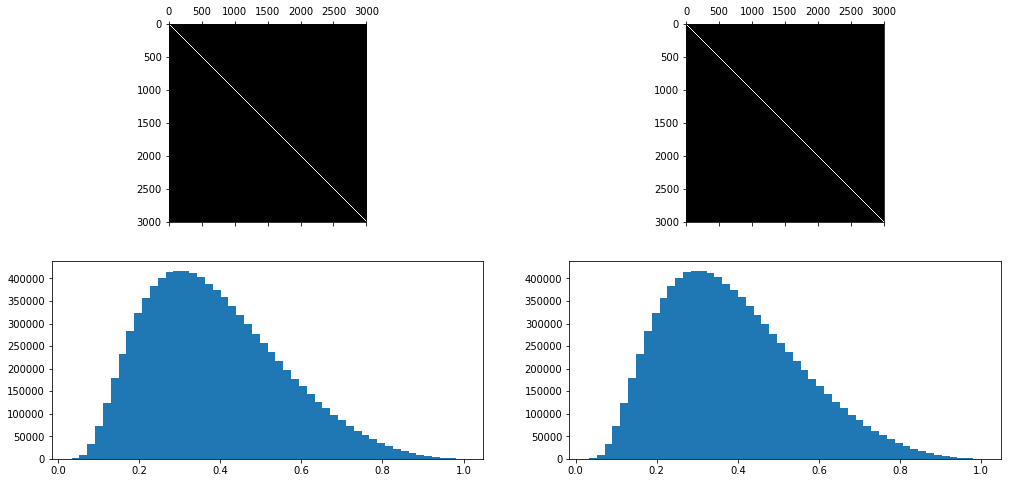

In [436]:

fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 3000

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])
   

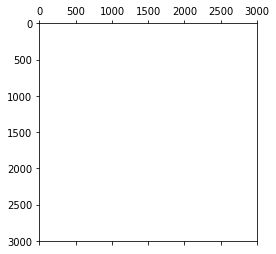

In [437]:
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)
plt.spy(laplacian.todense());

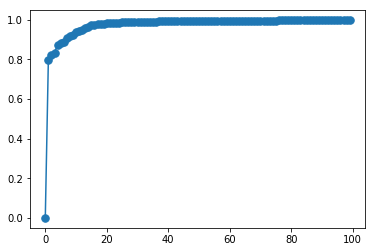

In [438]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=100,which='SM')
plt.plot(eigenvalues, '.-', markersize=15);


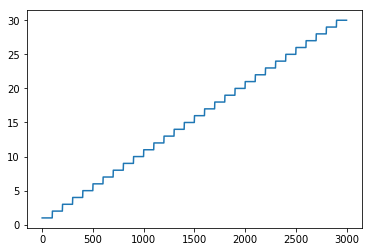

In [439]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
label_vec.plot()

In [440]:
# sample classes such as test and train have equal proportion of classes
train_size = 80
test_size = 20

train_x = np.array([])
train_y = np.array([])

test_x = np.array([])
test_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+test_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = label_vec[train_x_class]
    train_x = np.append(train_x, train_x_class)
    train_y = np.append(train_y, train_y_class)

    test_x_class = class_index[random_index[train_size:train_size+test_size]]
    test_y_class = label_vec[test_x_class]
    test_x = np.append(test_x, test_x_class)
    test_y = np.append(test_y, test_y_class)
    

In [441]:
# get features
train_features = eigenvectors[train_x.astype(int),:]
test_features = eigenvectors[test_x.astype(int),:]

In [442]:
clf  = GaussianNB()

In [443]:
clf.fit(train_features, train_y)

GaussianNB(priors=None)

In [444]:
predict_y = clf.predict(test_features)
print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))

accuracy :  0.636666666667


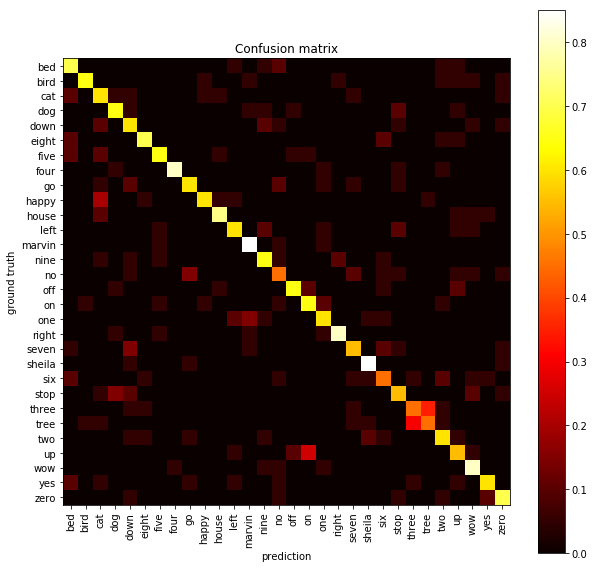

In [445]:
# confusion matrix from ADA
conf_mat=confusion_matrix(test_y,predict_y)

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(class_names))
plt.xticks(tick, class_names,rotation=90)
plt.yticks(tick, class_names)
plt.ylabel('ground truth')
plt.xlabel('prediction')
plt.title('Confusion matrix')
plt.colorbar()

In [446]:
# Cross Validation for all the words :
cv_accuracies = cross_val_score(clf, eigenvectors, label_vec, cv=100)
print('The average accuracy with CV is :' ,cv_accuracies.mean() , "(+/-)" ,cv_accuracies.std()* 2)

The average accuracy with CV is : 0.671666666667 (+/-) 0.159547972584


In [447]:
# Real accuracy considering only the main words :
class_names_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
mask_names_main = [True if name in class_names_list else False for name in class_names]
index_names_main = [i for i in range(len(mask_names_main)) if mask_names_main[i] == True]
inverted_index_names = dict(zip(index_names_main,range(len(index_names_main))))

# Creating the label names :
class_names_main = class_names[mask_names_main].tolist()
class_names_main.extend(["unknown"])

# Adapting the labels in the test and prediction sets :
test_y_adapted = np.array([inverted_index_names[int(test_y[i])] if test_y[i] in index_names_main else len(class_names_main)-1 for i in range(len(test_y)) ])
predict_y_adapted = np.array([inverted_index_names[int(predict_y[i])] if predict_y[i] in index_names_main else len(class_names_main)-1 for i in range(len(predict_y)) ])


In [448]:
acc_adapted = np.sum(test_y_adapted==predict_y_adapted)/len(test_y_adapted)
print('accuracy for main words classification : ', acc_adapted)

accuracy for main words classification :  0.673333333333


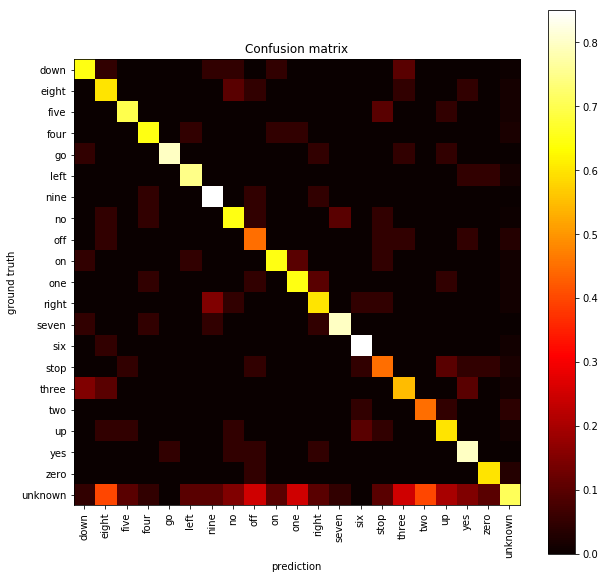

In [449]:
# Confusion matrix from ADA
conf_mat=confusion_matrix(test_y_adapted,predict_y_adapted)

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(class_names_main))
plt.xticks(tick, class_names_main,rotation=90)
plt.yticks(tick, class_names_main)
plt.ylabel('ground truth')
plt.xlabel('prediction')
plt.title('Confusion matrix')
plt.colorbar()